In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from mpl_toolkits.mplot3d import Axes3D
import time
import math

In [18]:
def box_muller(num_points):
    u1 = np.random.rand(num_points)
    u2 = np.random.rand(num_points)
    u1 = np.maximum(u1, 1e-10)  
    z0 = np.sqrt(-2 * np.log(u1)) * np.cos(2 * math.pi * u2)
    z1 = np.sqrt(-2 * np.log(u1)) * np.sin(2 * math.pi * u2)
    return z0, z1

def muller_method(N, num_points, radius=1):
    points = np.zeros((num_points, N))
    for i in range((N + 1) // 2):
        z0, z1 = box_muller(num_points)
        points[:, 2*i] = z0
        if 2*i + 1 < N:
            points[:, 2*i + 1] = z1
    norms = np.linalg.norm(points, axis=1, keepdims=True)
    return points / norms

In [ ]:
def rejection_sphere(N, num_points=1, radius=1):
    points = []
    while len(points) < num_points:
        # cube random numbers
        x = np.random.uniform(-1, 1, (num_points, N))
        # Rejection
        norms_sq = np.sum(x**2, axis=1)
        mask = (norms_sq <= 1)
        accepted = x[mask]
        # Step 3: Normalize
        if len(accepted) > 0:
            norms = np.sqrt(norms_sq[mask])
            y = accepted / norms[:, np.newaxis]
            points.extend(y)
    points = np.array(points[:num_points])
    return points
    

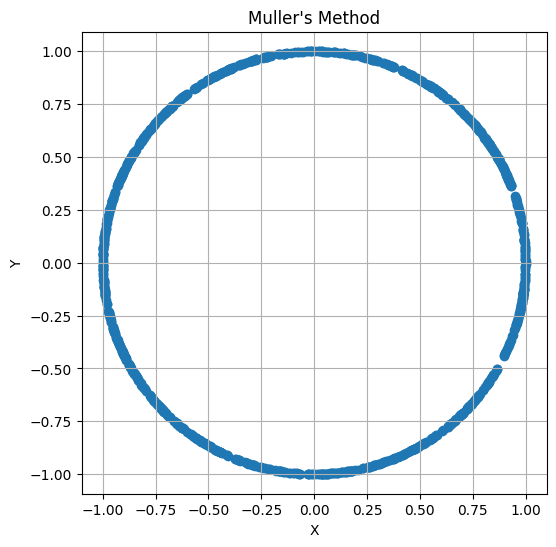

In [23]:

points_muller = muller_method(N=2, num_points=1000)

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(points_muller[:, 0], points_muller[:, 1])
plt.title("Muller's Method")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis("equal")
plt.show()

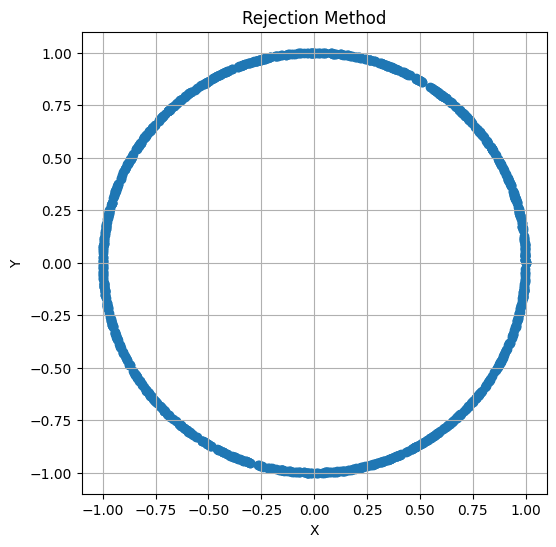

In [21]:
points_rejection = rejection_sphere(2,1000)
plt.figure(figsize=(6, 6))
plt.scatter(points_rejection[:, 0], points_rejection[:, 1])
plt.title("Rejection Method")
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [22]:
#time comparison
N = np.arange(3,20,3)
num_points = 10**3
muller = np.zeros(len(N))
rejection = np.zeros(len(N))
for i in range(len(N)):
    start = time.time()
    _ = muller_method(N[i], num_points)
    muller[i] = time.time() - start
for i in range(len(N)):    
    start = time.time()
    _ = rejection_sphere(N[i], num_points)
    rejection[i] = time.time() - start

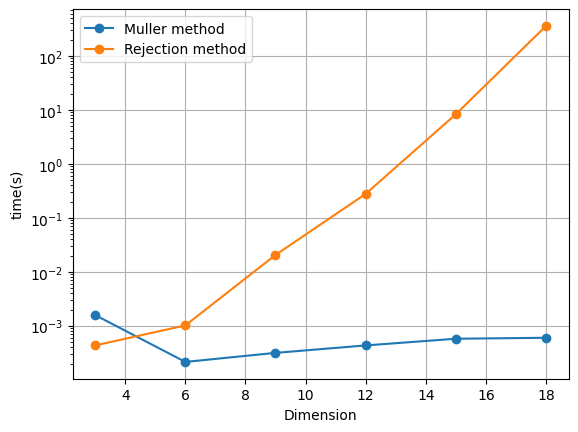

In [24]:
#plot comparison
plt.plot(N,muller,'-o',label='Muller method')
plt.plot(N,rejection,'-o',label='Rejection method')
plt.grid()
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("time(s)")
plt.yscale("log")
plt.show()

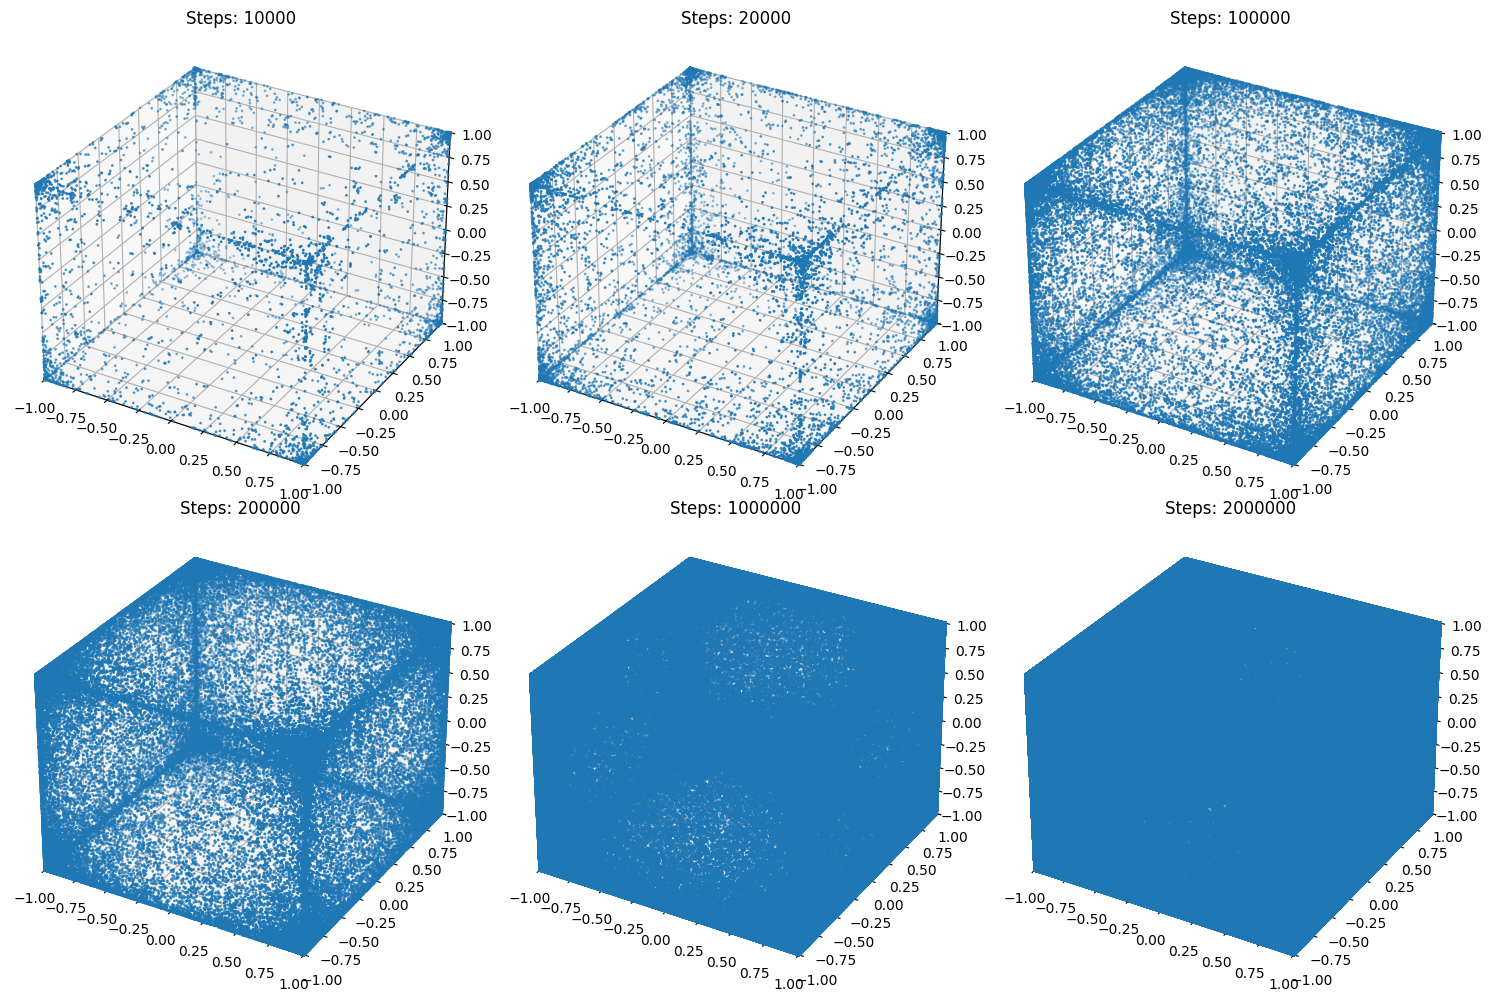

In [ ]:
def random_walk_on_cube(num_steps):
    current_point = np.array([1.0, 0, 0]) 
    directions = muller_method(3, num_steps)
    points = [current_point.copy()]

    for i in range(num_steps):
        direction = directions[i] / np.linalg.norm(directions[i])
        alpha = np.inf

        for j in range(3):
            if direction[j] != 0:
                possible_alpha = (np.sign(current_point[j]) * 1.01 - current_point[j]) / direction[j]
                if possible_alpha > 0:
                    alpha = min(alpha, possible_alpha)  

        if np.isinf(alpha):
            continue  
        next_point = current_point + alpha * direction
        max_idx = np.argmax(np.abs(next_point))  
        next_point[max_idx] = np.sign(next_point[max_idx])
        next_point = np.clip(next_point, -1.0, 1.0)
        if i % 2 == 1: 
            points.append(current_point)
        current_point = next_point  
    return np.array(points)

def plot_cube(num_steps):
    num_plots = len(num_steps)
    cols = 3  
    rows = (num_plots + cols - 1) // cols  
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    for i, num_steps in enumerate(num_steps):
        points = random_walk_on_cube(num_steps)
        ax = axes[i]
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
        ax.set_title(f"Steps: {num_steps}")
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
    plt.tight_layout()
    plt.show()
plot_cube([10 ** 4,2*(10**4), 10 ** 5, 2 * (10 ** 5), 10 ** 6, 2*(10 ** 6)])

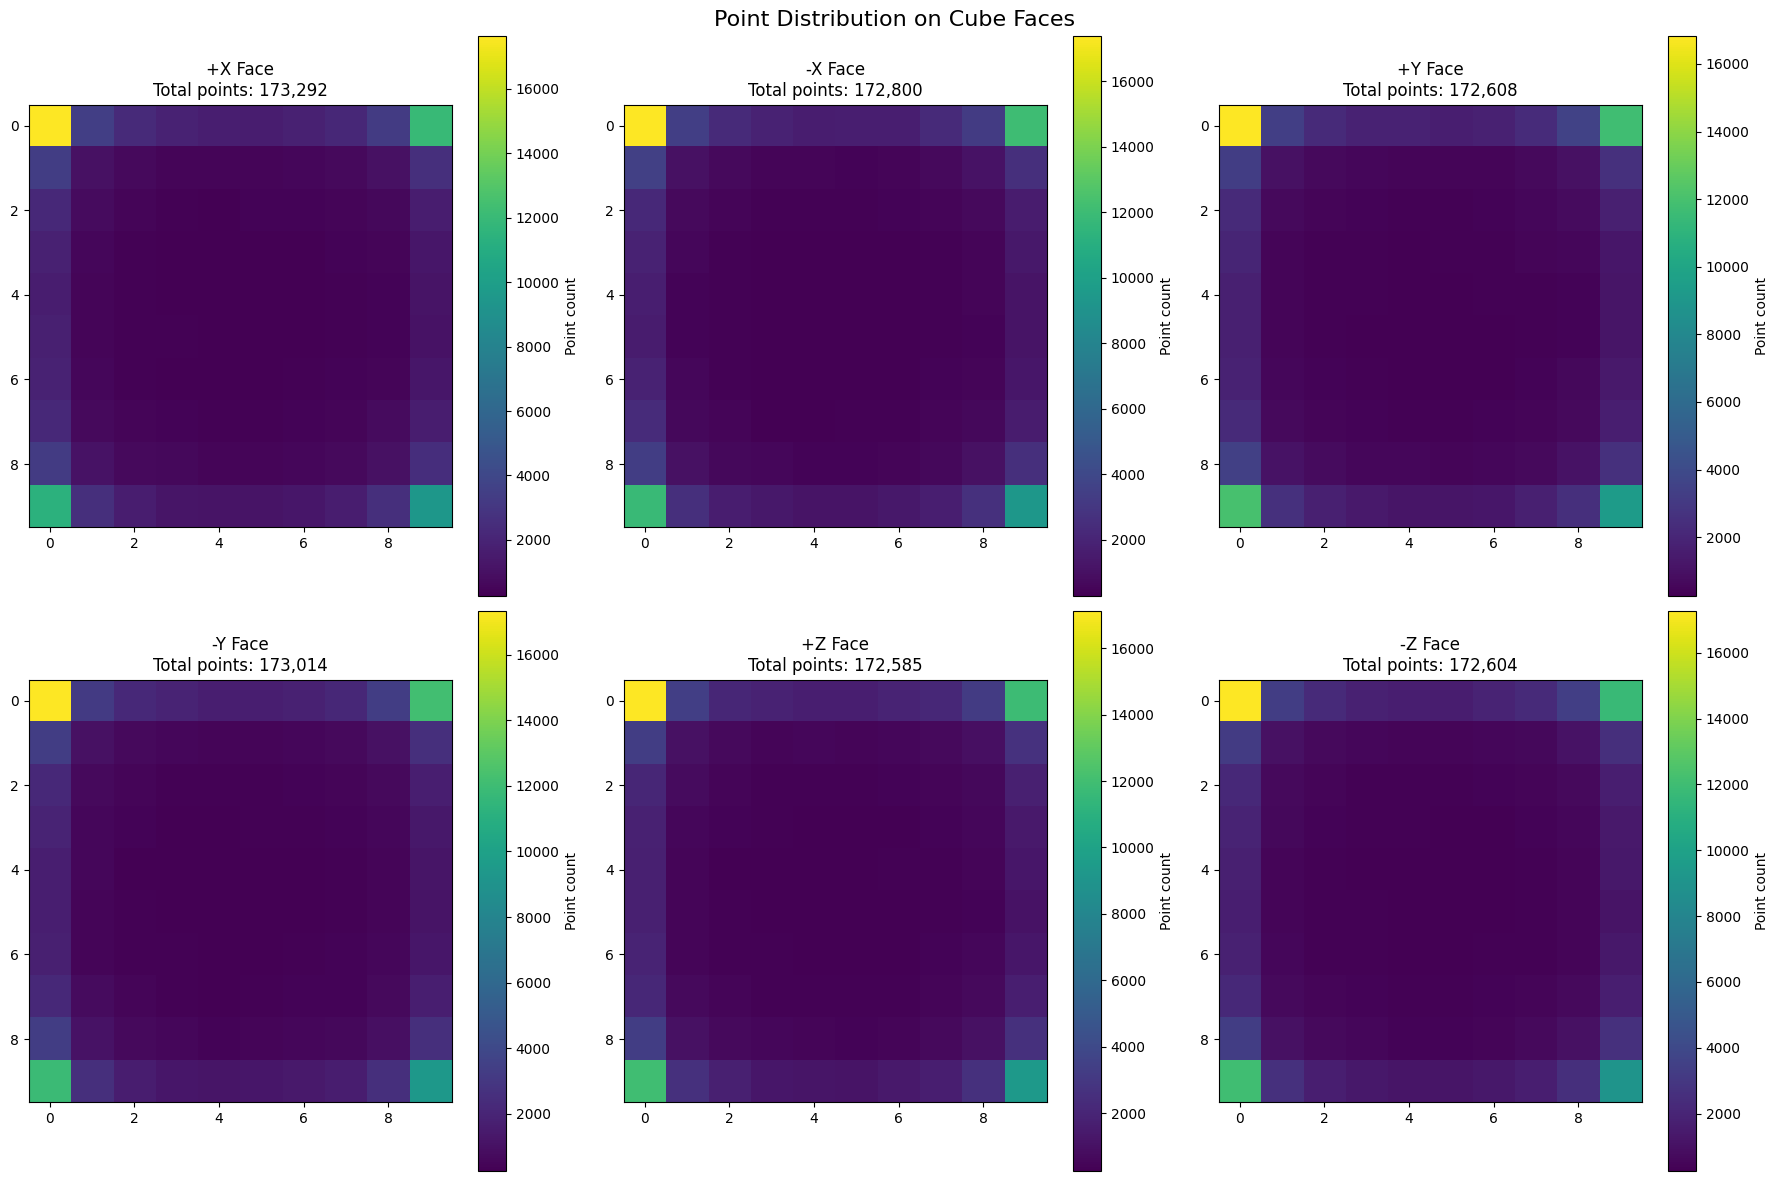

In [ ]:


def analyze_cube_uniformity(points):
    bins = 10 
    counts = np.zeros((6, bins, bins))
    face_labels = ['+X', '-X', '+Y', '-Y', '+Z', '-Z']
    
    # Define cube face boundaries
    edges = np.linspace(-1, 1, bins + 1)
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Point Distribution on Cube Faces', fontsize=16)
    
    for face in range(6):
        axis = face // 2          # 0=x, 1=y, 2=z
        sign = -1 if face % 2 else 1  # -1 or +1 face
        on_face = np.isclose(points[:, axis], sign)
        face_points = points[on_face]
        total_points = len(face_points)
        u_axis, v_axis = (axis + 1) % 3, (axis + 2) % 3
        u, v = face_points[:, u_axis], face_points[:, v_axis]
        u_bins = np.digitize(u, edges) - 1
        v_bins = np.digitize(v, edges) - 1
        #count
        for i in range(bins):
            for j in range(bins):
                counts[face, i, j] = np.sum((u_bins == i) & (v_bins == j))
        
        # Plot 
        row, col = face // 3, face % 3
        img = axs[row, col].imshow(counts[face], cmap='viridis')
        axs[row, col].set_title(f'{face_labels[face]} Face\nTotal points: {total_points:,}')
        plt.colorbar(img, ax=axs[row, col], label='Point count')
    
    plt.tight_layout()
    plt.savefig('cube_uniformity_subplots.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return counts

N = 2 * (10**6)
points = random_walk_on_cube(N)
counts = analyze_cube_uniformity(points)


In [44]:
#capacitance
theoretical_capacitance = 1.33266
theoretical_capacitance_std = 0.08844
trials = 10
estimates = np.zeros(trials)
for i in range(trials):
    y = random_walk_on_cube(10**7)
    distances = np.linalg.norm(y, axis=1)
    estimates[i] = 1/np.mean(1/distances)
std_estimate = np.std(estimates)
mean_estimate = np.mean(estimates)
relative_error = np.abs(mean_estimate - theoretical_capacitance) / theoretical_capacitance

print(f"""
Capacitance Estimation Results:
- Mean estimate: {mean_estimate:.5f} ± {std_estimate:.5f}
- Theoretical value: {theoretical_capacitance:.5f}
- Relative error: {relative_error*100:.2f}%
- Standard deviation across trials: {std_estimate:.5f}
""")


Capacitance Estimation Results:
- Mean estimate: 1.46640 ± 0.00019
- Theoretical value: 1.33266
- Relative error: 10.04%
- Standard deviation across trials: 0.00019



In [43]:
print(f"""
Capacitance Estimation Results:
- Mean estimate: {mean_estimate:.5f} ± {std_estimate:.5f}
- Theoretical value: {theoretical_capacitance:.5f}
- Relative error: {relative_error*100:.2f}%
- Standard deviation across trials: {std_estimate:.5f}
""")


Capacitance Estimation Results:
- Mean estimate: 1.46650 ± 0.00057
- Theoretical value: 1.33266
- Relative error: 10.04%
- Standard deviation across trials: 0.00057

